# Autoregression Models for Time Series Forecasting With Python

* Ref: [https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)
* Data: [daily-min-temperatures.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv)


## Autoregression:
* 下一個時刻的 observation 是可由先前時刻的 observation 的 regression 求得
    * $ X(t+1) = b0 + b1X(t) + b2X(t-1) + b3X(t-2) + \cdots$
    * 先前時刻的 observation 就叫做 lag

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

## 1. Load data

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/daily-min-temperatures.csv',
                 header=0,
                 index_col=0,
                 parse_dates=True)
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


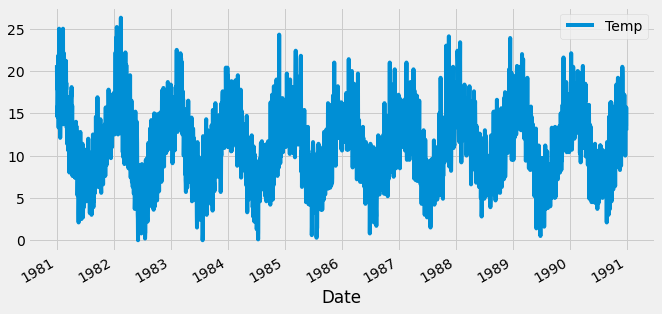

In [ ]:
# Show the time series distribution
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax)
plt.show()

## 2. Analysis

### Check for autocorrelation

#### Use `pd.plotting.lag_plot()` to show the correlation between time steps $t$ and $t+1$

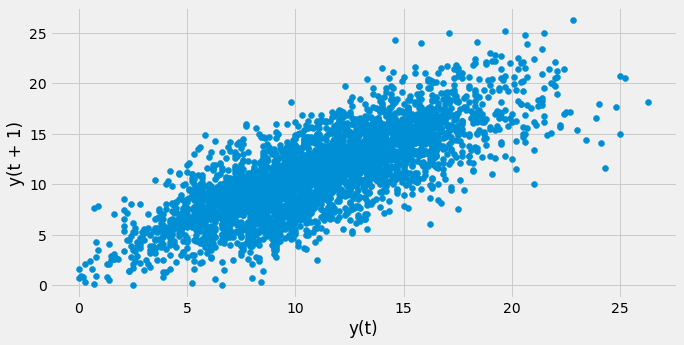

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
pd.plotting.lag_plot(df, ax=ax)
plt.show()

There is positive correlation between time steps $t$ and $t+1$

### Autocorrelation plots

#### Use `pd.plotting.autocorrelation_plot()`
* 虛線 99% confidence level，實線 95% confidence level
    * 比 95% confidence level 還高的部分表示該 lag 真的是有 correlation 的 (而不是統計 fluctuations)

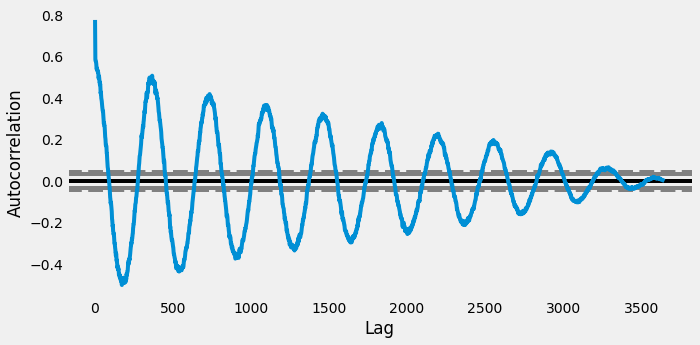

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
pd.plotting.autocorrelation_plot(df, ax=ax)
plt.show()

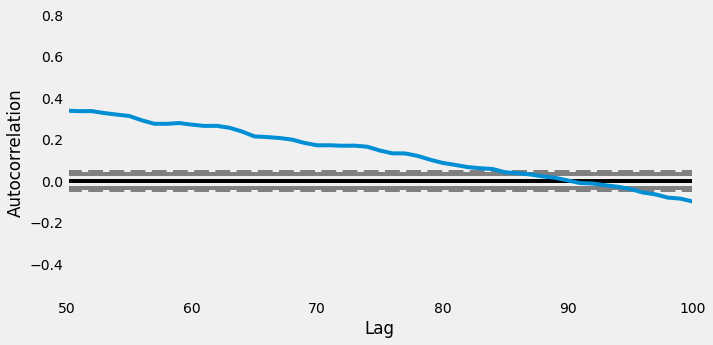

In [ ]:
# zoom in the plot
fig, ax = plt.subplots(figsize=(10, 5))
pd.plotting.autocorrelation_plot(df, ax=ax)
ax.set_xlim(50, 100)
plt.show()

The first to cross 95% confidence level is about lag=85

### Use `statsmodels.graphics.tsaplots.plot_acf()`

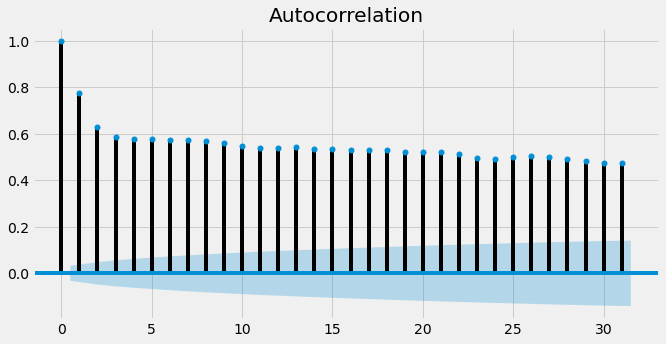

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df, lags=31, ax=ax) # only show the first 31 lags
plt.show()

### Use Pearson correlation coefficient to check the correlation

In [ ]:
df_temperature = pd.DataFrame(df.values)
df_final = pd.concat([df.shift(1), df], axis=1)
df_final.columns = ['t', 't+1']

In [ ]:
df_temperature.head()

,0
0,20.7
1,17.9
2,18.8
3,14.6
4,15.8


In [ ]:
df_final.head()

,t,t+1
Date,,
1981-01-01,NaN,20.7
1981-01-02,20.7,17.9
1981-01-03,17.9,18.8
1981-01-04,18.8,14.6
1981-01-05,14.6,15.8


In [ ]:
corr = df_final.corr()
print(corr)

           t      t+1
t    1.00000  0.77487
t+1  0.77487  1.00000


這樣是計算 $t$ 和 $t+1$ 兩個 lags 之間的 correlation 而已，如果要用這個方法看其他的 lags 之間的 correlation 就要一個一個算，因此用 `pd.plotting.autocorrelation_plot()` 會比較方便

## 3. Forecast

### Persistence model

Create a baseline model to predict the temperatures of the last 7 days
* Use the last observation as prediction
* Not make a 7 day forecast but 7 **one day forecast**

In [ ]:
# split into train and test sets
X = df_final.values
train, test = X[1: len(X) - 7], X[len(X) - 7:] # train 要從 index=1 開始因為 index=0 時 X(t) = NaN
train_X, train_y = train[:, 0], train[:, 1]
test_X, test_y = test[:, 0], test[:, 1]

In [ ]:
print(len(X), type(X), X)
print(len(train), type(train), train)
print(len(test), type(test), test)

3650 <class 'numpy.ndarray'> [[ nan 20.7]
 [20.7 17.9]
 [17.9 18.8]
 ...
 [13.6 13.5]
 [13.5 15.7]
 [15.7 13. ]]
3642 <class 'numpy.ndarray'> [[20.7 17.9]
 [17.9 18.8]
 [18.8 14.6]
 ...
 [13.1 13.2]
 [13.2 13.9]
 [13.9 10. ]]
7 <class 'numpy.ndarray'> [[10.  12.9]
 [12.9 14.6]
 [14.6 14. ]
 [14.  13.6]
 [13.6 13.5]
 [13.5 15.7]
 [15.7 13. ]]


We use start index 1 in X because X[0, 0] = NaN

In [ ]:
print(train_X, train_y)

[20.7 17.9 18.8 ... 13.1 13.2 13.9] [17.9 18.8 14.6 ... 13.2 13.9 10. ]


In [ ]:
print(test_X, test_y)

[10.  12.9 14.6 14.  13.6 13.5 15.7] [12.9 14.6 14.  13.6 13.5 15.7 13. ]


In [ ]:
# persistence model
def model_persistence(x):
    return x # 直接使用最後一個 observation

# walk-forward validation
predictions = list()

for x in test_X: # loop test_X 中的每個值，為每個值產生一個預測結果，所以這裡是產生 7 個隔天的溫度 
    y_hat = model_persistence(x)
    predictions.append(y_hat)

print(predictions)

[10.0, 12.9, 14.6, 14.0, 13.6, 13.5, 15.7]


In [ ]:
from sklearn.metrics import mean_squared_error

test_score = mean_squared_error(test_y, predictions)
print(f'Test MSE: {test_score}')

Test MSE: 3.4228571428571413


This MSE is the baseline performance. We want to find a model to make predictions with **lower MSE** (i.e. better results)

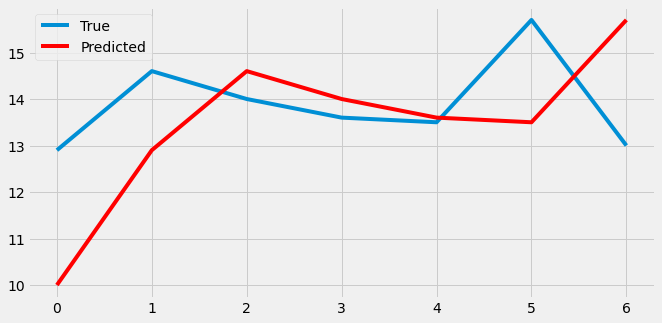

In [ ]:
# plot predictions vs expected
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(test_y) # 真值
plt.plot(predictions, color='red') # 預測值
plt.legend(['True', 'Predicted'])
plt.show()

### Autoregression model

In [ ]:
pip search statsmodels

statsmodels (0.12.0)  - Statistical computations and models for Python
  INSTALLED: 0.12.0 (latest)
statsmodels-dq (3.0)  - Statistical computations and models for Python
sm2 (0.1.3)           - Bugfix Fork of statsmodels


`AutoReg` 需要 statsmodels >= 0.11.1 所以要更新一下套件

In [ ]:
pip install statsmodels --upgrade

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.12.0)


In [ ]:
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

# load dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/daily-min-temperatures.csv',
                 header=0,
                 index_col=0,
                 parse_dates=True,
                 squeeze=True) # squeeze 會把資料讀入成 series
print(type(df))

<class 'pandas.core.series.Series'>


In [ ]:
# split dataset
X = df.values
train, test = X[1: len(X) - 7], X[len(X) - 7:]
print(len(X), type(X), X)
print(len(train), type(train), train)
print(len(test), type(test), test)

3650 <class 'numpy.ndarray'> [20.7 17.9 18.8 ... 13.5 15.7 13. ]
3642 <class 'numpy.ndarray'> [17.9 18.8 14.6 ... 13.2 13.9 10. ]
7 <class 'numpy.ndarray'> [12.9 14.6 14.  13.6 13.5 15.7 13. ]


In [ ]:
# train autoregression
model = AutoReg(train, lags=29) # 用先前的 29 個資料點來預測下一個時刻的
model_fit = model.fit()
print(f'Coefficients: {model_fit.params}')

Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [ ]:
# make predictions
start = len(train)
end = len(train) + len(test) - 1
# 一次預測從 start 到 end 的範圍內 (包含 end) 的結果
predictions = model_fit.predict(start=start,
                                end=end,
                                dynamic=False) # dynamic=False 用 t的真實值來預測 t+1 的，dynamic=True 用 t-1 預測到 t 的值來預測 t+1 的

for i in range(len(predictions)):
    print(f'predicted={predictions[i]}, expected={test[i]}')

mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f'Test MSE: {mse}, RMSE: {rmse}')

predicted=11.871274847727836, expected=12.9
predicted=13.05379421722983, expected=14.6
predicted=13.532590951105139, expected=14.0
predicted=13.243126458186234, expected=13.6
predicted=13.091438030687994, expected=13.5
predicted=13.146988838852254, expected=15.7
predicted=13.17615345557423, expected=13.0
Test MSE: 1.5015252310069438, RMSE: 1.2253673861364778


The MSE of baseline model and AR model are 3.42 and 1.50, respectively. So the AR model get a better result

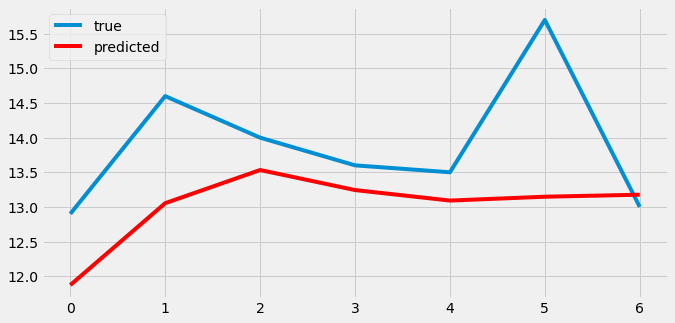

In [ ]:
# plot results
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['true', 'predicted'])
plt.show()

### Update model when there are new data
* 當有新的 data 時可以
    * 每次重新讀取全部的資料，然後重新 fit 一次，再來做預測
        * 這在資料量很大的時候不方便
    * 用既有的係數來預測，但是這樣就必須保存先前 lag=k 個的資料點，才能用這 k 個資料預測下一個時刻的
        * 這樣就假設一開始預測到的模型是正確的，所以係數不會變

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# load dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/daily-min-temperatures.csv',
                 header=0,
                 index_col=0,
                 parse_dates=True,
                 squeeze=True)

# split dataset
X = df.values
train, test = X[1: len(X) - 7], X[len(X) - 7:]

#train autoregression
window = 29
model = AutoReg(train, lags=29)
model_fit = model.fit()
coef = model_fit.params # 這裡假設 model 是正確的所以 coef 不會改變
print(coef)

[ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


coef[0] 是截距，coef[1] 是 t 的係數, coef[2] 是 t-1 的係數, coef[3] 是 t-2 的係數，以此類推

In [ ]:
# walk forward over time steps in test
history = train[len(train) - window:] # 保存先前 lags=k 的資料點，這邊是保存 29 個點
history = [history[i] for i in range(len(history))] # 把原本的 numpy.ndarray 變成 list

history[0] 是 t-28 的結果, history[1] 是 t-27 的結果, ..., history[-1] 是 t 的結果，所以正好和 coef 對應的 t 相反

In [ ]:
predictions = list()

for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length - window, length)]
    y_hat = coef[0] # 截距
    for d in range(window):
        y_hat += coef[d + 1] * lag[window - d - 1] # 要注意係數與 lag 的配對要正確
    obs = test[t]
    predictions.append(y_hat)
    history.append(obs) # 把新的真實值放入 history 中
    print(f'predicted = {y_hat}, expected = {obs}')

mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f'Test MSE: {mse}, RMSE: {rmse}')

predicted = 11.871274847727838, expected = 12.9
predicted = 13.659296925615934, expected = 14.6
predicted = 14.349245594273242, expected = 14.0
predicted = 13.427453782606094, expected = 13.6
predicted = 13.374877458781492, expected = 13.5
predicted = 13.479990772376276, expected = 15.7
predicted = 14.76514638091346, expected = 13.0
Test MSE: 1.4506829660623684, RMSE: 1.2044430107158945


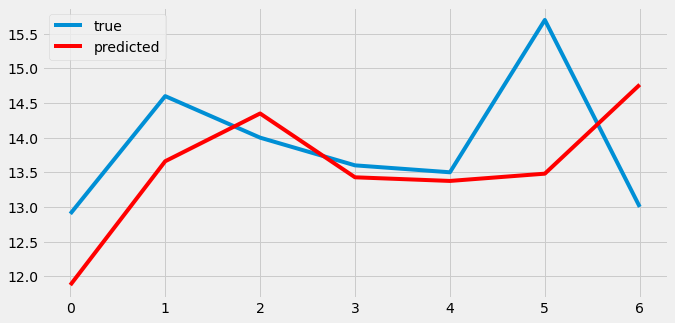

In [ ]:
# plot results
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['true', 'predicted'])
plt.show()